# Notebook 6: Population Decoding

Computational Biology 2 - WS 23/24

Material created by Katharina Bracher and Florian Eberhardt.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

---
## Population Coding in Vision

Information is encoded in the brain by populations or clusters of cells, rather than by single cells. This encoding strategy is known as population coding.

<img src="https://www.cns.nyu.edu/~david/courses/perception/lecturenotes/V1/LGN-V1-slides/Slide15.jpg" width="500">

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2F35039062/MediaObjects/41583_2000_Article_BF35039062_Fig1_HTML.gif" width="500">

a | Bell-shaped tuning curves to direction for 16 neurons. b | A population pattern of activity across 64 neurons with bell-shaped tuning curves in response to an object moving at −40°. The activity of each cell was generated using eqn 1, and plotted at the location of the preferred direction of the cell. The overall activity looks like a `noisy' hill centred around the stimulus direction. c | Population vector decoding fits a cosine function to the observed activity, and uses the peak of the cosine function, ŝ, as an estimate of the encoded direction. d | Maximum likelihood fits a template derived from the tuning curves of the cells. More precisely, the template is obtained from the noiseless (or average) population activity in response to a stimulus moving in direction s. The peak position of the template with the best fit, ŝ, corresponds to the maximum likelihood estimate, that is, the value that maximizes P(r | s).

Source: https://www.nature.com/articles/35039062

---

## Head direction cells in flys
https://www.youtube.com/watch?v=9x3VXgKS7VI

Today we will simulate a population of orientation-selective neurons that encode the fly's head direction and use population vectors to first estimate the neurons preferred orientations and then decode the fly's head direction  from the population activity.

## Simulation of recording data

To simulate the neurons we will use: 
- Poisson spike statistics,
- Gaussian tuning of width $\sigma=60°$ and 
- maximal response of 100 spikes/sec

Neurons have random preferred orientations between 0-360° 


In [110]:
# Gaussian tuning, Poisson firing
def gaussian(A, x, sigma):
    return A*np.exp(-(x)**2/(2*sigma**2))

def poissonspikes(rate, time):
    spikes = []
    t = 0
    while t < time:
        t -= np.log(np.random.rand())/rate
        spikes.append(t)
    return spikes[:-1]

def get_spike_train(prefori, stimori, time, tunsig=60, tunmax=100):
    """
    prefori: preferred orientation of neuron 0-360
    stimor: stimulus orientation of neuron 0-360
    tunsig: width of tuning curves [deg]
    tunmax: max firing rate, amplitude of gaussian tuning curve
    """
    rad = (prefori/2.-stimori/2.)/180.*np.pi
    x = np.arcsin(np.abs(np.sin(rad)))*180/np.pi
    mean_rate = gaussian(tunmax, x, tunsig/2.)
    spike_train = poissonspikes(mean_rate, time)
    return np.array(spike_train)
    

In [111]:
t = 10 # s
n_neurons = 50
n_stimuli = 36
n_test = 5
preferred_orientations = np.random.rand(n_neurons)*360.
stimulus_orientations_train = np.arange(n_stimuli)/n_stimuli*360.
stimulus_orientations_test = np.arange(n_test)/n_test*360.

In [114]:
recordings_train = pd.DataFrame(index=range(n_neurons), columns=stimulus_orientations_train, dtype='object')
for stim in stimulus_orientations_train:
    for i, pref in enumerate(preferred_orientations):
        st = get_spike_train(pref, stim, t)  
        recordings_train.loc[i,stim]=st.tostring()
        
recordings_test = pd.DataFrame(index=range(n_neurons), columns=stimulus_orientations_test, dtype='object')
for stim in stimulus_orientations_test:
    for i, pref in enumerate(preferred_orientations):
        st = get_spike_train(pref, stim, t)  
        recordings_test.loc[i,stim]=st.tostring()

In [121]:
data = {
    "preferred_orientations": preferred_orientations,
    "stimulus_orientations_train": stimulus_orientations_train,
    "stimulus_orientations_test":stimulus_orientations_test,
    "neurons": list(range(n_neurons)),
    "recordings_train": recordings_train,
    "recordings_test": recordings_test,
    "time": t
}

pickle.dump(data,open('./data/population_recordings.pcl','wb'))

### Load data

In [2]:
data = pickle.load(open('./data/population_recordings.pcl','rb'))

preferred_orientations = data["preferred_orientations"]
stimulus_orientations_train = data["stimulus_orientations_train"]
stimulus_orientations_test = data["stimulus_orientations_test"]
neurons = data['neurons']
recordings_train = data["recordings_train"]
recordings_test = data["recordings_test"]
t = data['time']

def read_spike_times(recordings, neuron, stim_orientation):
    st = recordings.loc[neuron, stim_orientation]
    st = np.frombuffer(st, dtype=float)
    return st

In [3]:
ni = neurons[1]
stim = stimulus_orientations_train[4]
print('neuron:', ni)
print('head direction:', stim)
print('spike times:',read_spike_times(recordings_train, ni, stim))

neuron: 1
head direction: 40.0
spike times: [0.09292701 0.11999187 0.17817607 0.18131857 0.26907239 0.372534
 0.4351035  0.44058135 0.47262364 0.49244651 0.49707111 0.54719908
 0.68718636 1.10071975 1.11630772 1.42148289 1.44227269 1.53956907
 1.57830403 1.68551129 1.72189407 1.73130681 1.73679472 1.81606822
 1.82959407 1.84330603 1.85463438 1.85731116 2.00688521 2.06737075
 2.16518624 2.29088348 2.37924501 2.387674   2.38797617 2.41789004
 2.45687777 2.48360143 2.51128296 2.5548427  2.5617728  2.60102699
 2.6102038  2.70784322 2.76170128 3.0423962  3.14177236 3.14489783
 3.15921038 3.27287378 3.37134111 3.43517415 3.5537352  4.14259165
 4.35550551 4.56360927 4.69978761 4.74611087 4.79121768 4.8679919
 4.86969658 4.92654877 4.97370581 5.06407543 5.0879831  5.23383913
 5.39230079 5.41713568 5.44157366 5.47803967 5.52294716 5.74234296
 5.93486394 5.94906681 5.97166858 6.0009813  6.04889183 6.09520286
 6.18484129 6.1900686  6.25818183 6.34909072 6.37615509 6.44811576
 6.57048332 6.6390894

### Problem 1: Spike count rate
FOr each neuron in the data set estimate the mean spike count rate for all stimuli (head direction).

- The recorded neurons can be found in the np-array: `neurons`
- The stimulus head direction can be found in the np-array: `stimulus_orientations_train`
- recording data can be found in:`recordings_train`
- to get the spike times call the function: `read_spike_times`
- call matshow() from pyplot to visualize the spike count rates depending on neuron and stimulus

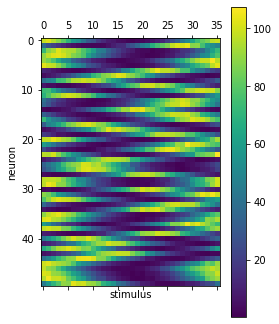

In [4]:
def estimate_rate(recordings, neuron, stim_orientation, t):
    st = read_spike_times(recordings, neuron, stim_orientation)
    r = len(st)/t
    return r

n_neurons = len(neurons)
n_stim = len(stimulus_orientations_train)
rates_train = np.zeros((n_neurons,n_stim ))
for ni in neurons:
    for j,soj in enumerate(stimulus_orientations_train):
        rates_train[ni,j] = estimate_rate(recordings_train,ni,soj,t)
mat = plt.matshow(rates_train)
plt.ylabel('neuron')
plt.xlabel('stimulus')
cbar = plt.colorbar(mat)

### Problem 2: Tuning curve
Each recorded cell responds best to a certain head direction. Visualize the tuning curves for different cells depending on the stiumulus (orientation / head direction). Plot the spike count rate of a cell depending on the stimulus.

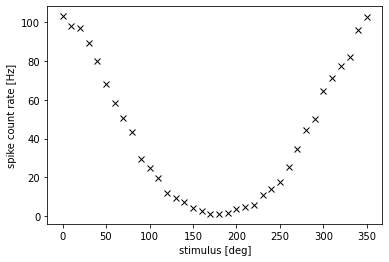

In [23]:
plt.plot(stimulus_orientations_train,rates_train[5],'kx')
plt.xlabel('stimulus [deg]')
plt.ylabel('spike count rate [Hz]')
plt.show()

### Problem 3: Preferred orientation decoding 
Estimate the preferred orientations of each individual neuron. You can do this by representing all stimulus directions by vectors in a 2D cartesian coordinate system. Wheight each vector by the spike count rate of a cell for this particular stiumulus and then sum over all vectors. The resulting vector is the preferred orientation of the neuron. Compare the estimated preferred orientations to the actual preferred orientations.

Text(0, 0.5, 'actual tuning')

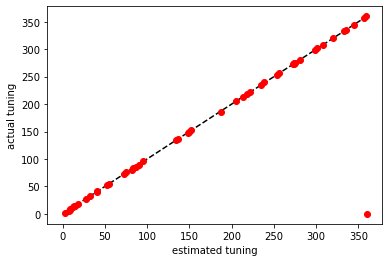

In [24]:
def population_vector(rates, orientations):
    x = np.cos(np.array(orientations)/180.*np.pi)
    y = np.sin(np.array(orientations)/180.*np.pi)
    pop_vector = np.sum(x*rates), np.sum(y*rates)
    pop_vector = pop_vector / np.sqrt(np.sum(np.square(pop_vector)))
    return pop_vector

def pop_vector_to_deg(v):
    return (np.arctan2(v[1],v[0])*180./np.pi + 360) % 360.
    

orientation_estimates = []
for i in range(n_neurons):
    v=population_vector(rates_train[i], stimulus_orientations_train)
    orientation_estimates.append(pop_vector_to_deg(v))

plt.plot([0,360],[0,360],'k--' )
plt.plot(orientation_estimates, preferred_orientations, 'ro')
plt.xlabel('estimated tuning')
plt.ylabel('actual tuning')


### Problem 4: Population decoding of head direction
Make use of population vectors to decode the the stimulus orientations in the test data set. 
You have computed the preferred orientation of each cell in the previous excercise. Represent the preferred orientation of each cell as a vector in a 2D cartesian space. Wheight each vector by the spike count rate of the cell and then sum over all vectors. The orientation of the resulting vector is the decoded stimulus. Compare the decoded values to the presented stimuli.

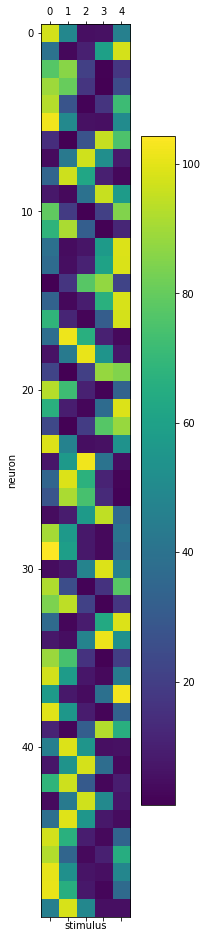

In [10]:
def decode_head_direction(rates, preferred_orientations):
    v=population_vector(rates, preferred_orientations)
    head_direction = pop_vector_to_deg(v)
    return head_direction

n_neurons = len(neurons)
n_test = len(stimulus_orientations_test)
rates_test = np.zeros((n_neurons, n_test))
for i in range(n_neurons):
    for j,s in enumerate(recordings_test.keys()):
        rates_test[i,j] = estimate_rate(recordings_test,i,s,t)
mat = plt.matshow(rates_test)
plt.ylabel('neuron')
plt.xlabel('stimulus')
cbar = plt.colorbar(mat)


0.0 4.280263208767394
72.0 50.100055422259516
144.0 128.2642007609444
216.0 234.39345502926764
288.0 300.9139036320421


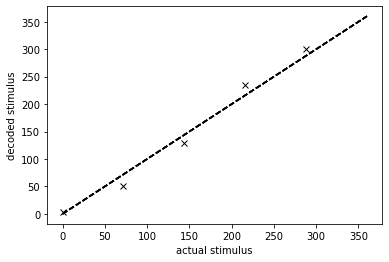

In [18]:
for i, so in enumerate(stimulus_orientations_test):
    o = decode_head_direction(rates_test[:,i],preferred_orientations)
    print(so,o)
    plt.plot([so], [o], 'kx')
    plt.plot([0,360],[0,360],'k--' )
    plt.xlabel('actual stimulus')
    plt.ylabel('decoded stimulus')
